# Active Learning for Text Classification using Small-Text
## 01 - Introduction

This tutorial shows how to use [small-text](https://github.com/webis-de/small-text) to perform active learning for text classification using state-of-the-art transformer models.


### Installation

Besides small-text, we also install [datasets](https://github.com/huggingface/datasets) to load an example dataset and [matptlotlib](https://matplotlib.org/) to plot the learning curves at the end.

In [ ]:
%pip install small-text[transformers]==1.0.0b3  # use "small-text" without "[transformers]" if you want to work on the CPU only

# additional dependencies for this example
%pip install datasets matplotlib seaborn

: 

### Preparation

Here we configure the loggging and display progress bars display of the `datasets` library to improve its appearance in the notebook. You can skip this when reading for the first time if you are only interested in active learning.

In [ ]:
import datasets
datasets.logging.set_verbosity_error()

# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

Moreover, we update the default matplotlib settings to receive a more visually appealing plot at the end of this tutorial.

In [29]:
from matplotlib import rcParams
rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 16})

Finally, we will fix the random seeds so that readers do not get confused when the results change upon repeated execution.

In [31]:
import torch
import numpy as np

seed = 2022
torch.manual_seed(seed)
np.random.seed(seed)

### Loading the Data

First we load rotten tomatoes dataset. This dataset contains movie reviews sentences, which are labeled by their sentiment as either positive or negative.

In [32]:
import logging

'''
AG's News = ag_news
TweetEval = tweet_eval
TREC = trec
'''
raw_dataset = datasets.load_dataset('ag_news')
num_classes = np.unique(raw_dataset['train']['label']).shape[0]

# Show how many train and test element we have
print(raw_dataset)

print('First 10 training samples:\n')
for i in range(10):
    print(raw_dataset['train']['label'][i], ' ', raw_dataset['train']['text'][i])

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
First 10 training samples:

2   Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
2   Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
2   Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
2   Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from 

### Preparing the Data

Next, we have to convert this raw text data into a format usable by small-text. Since the transformer-based classification in small-text uses huggingface transformers this step is pretty similar to the preprocessing you may know from transformers, with the addition that the end result must be a `TransformersDataset`. In this example, we use `bert-base-uncased` as transformer model.

In [33]:
from transformers import AutoTokenizer

transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

We define a small helper function `get_transformers_dataset()` with delegates to `tokenizer.encode_plus()` and finally builds a `TransformersDataset` instance. 

In [34]:
from small_text.integrations.transformers.datasets import TransformersDataset


def get_transformers_dataset(tokenizer, data, labels, max_length=60):

    data_out = []

    for i, doc in enumerate(data):
        encoded_dict = tokenizer.encode_plus(
            doc,
            add_special_tokens=True,
            padding='max_length',
            max_length=max_length,
            return_attention_mask=True,
            return_tensors='pt',
            truncation='longest_first'
        )

        data_out.append((encoded_dict['input_ids'], encoded_dict['attention_mask'], labels[i]))

    return TransformersDataset(data_out)


train = get_transformers_dataset(tokenizer, raw_dataset['train']['text'], raw_dataset['train']['label'])
test = get_transformers_dataset(tokenizer, raw_dataset['test']['text'], raw_dataset['test']['label'])

### Setting up the Active Learner

Now we constrauct a `PoolBasedActiveLearner` instance which requires a classifier factory, a query strategy, and the train dataset.

To obtain a first model, we initialize the active learner by providing the true labels for 10 sentences. This corresponds to an initial labeling the real-world setting.

In [35]:
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
print(local_device_protos)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17958912190956221856
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 49515528192
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 823116102940749928
physical_device_desc: "device: 0, name: Quadro RTX 8000, pci bus id: 0000:3b:00.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 49515528192
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 4163586647419154832
physical_device_desc: "device: 1, name: Quadro RTX 8000, pci bus id: 0000:d8:00.0, compute capability: 7.5"
xla_global_id: 2144165316
]


2022-05-13 09:16:20.084789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 47221 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-05-13 09:16:20.085198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 47221 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:d8:00.0, compute capability: 7.5


In [36]:
from small_text.active_learner import PoolBasedActiveLearner

from small_text.initialization import random_initialization_balanced
from small_text.integrations.transformers import TransformerModelArguments
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.query_strategies import LeastConfidence
from small_text.integrations.transformers import TransformerModelArguments


# simulates an initial labeling to warm-start the active learning process
def initialize_active_learner(active_learner, y_train):

    # We take 25 samples (n_samples) for Initalization 

    indices_initial = random_initialization_balanced(y_train, n_samples=25)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])

    return indices_initial



transformer_model = TransformerModelArguments(transformer_model_name)

''' 
number of epochs for
- AG's News: 50
- TweetEval: 15
- TREC-6: 15
'''

clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 32,
                                                                 'class_weight': 'balanced',
                                                                 'num_epochs': 50
                                                                }))
query_strategy = LeastConfidence()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

0
1
2
3
4
5
6
7
8


### Active Learning Loop

The main active learning loop queries the unlabeled pool and thereby decides which documents are labeled next.
We then provide the labels for those documents and the active learner retrains the model.
After each query, we evaluate the current model against the test set and save the result.


Note: This is active learning as it is done in a scientific simulation. In reality, the label feedback would have been given by human annotators, and moreover, we would not be able to measure the test accuracy.

In [38]:
from sklearn.metrics import accuracy_score

#We make 20 iterations of our active learning algorithm, so num_queries = 20
num_queries = 20


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)

    print('Train accuracy: {:.4f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.4f}'.format(test_acc))
    
    return test_acc


results = []
results.append(evaluate(active_learner, train[indices_labeled], test))

    
for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples -> we keep this at num_samples = 20
    indices_queried = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[indices_queried]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], test))


Train accuracy: 0.7600
Test accuracy: 0.4028
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
---------------
Iteration #0 (45 samples)
Train accuracy: 1.0000
Test accuracy: 0.7859
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
---------------
Iteration #1 (65 samples)
Train accuracy: 1.0000
Test accuracy: 0.8317
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
---------------
Iteration #2 (85 samples)
Train accuracy: 1.0000
Test accuracy: 0.8675
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
---------------
Iteration #3 (105 samples)
Train accuracy: 0.9429
Test accuracy: 0.6833
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
---------------
Iteration #4 (125 samples)
Train accuracy: 0.9600
Test accuracy: 0.7818
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17

### Plotting the Results

Using the previously saved results we can plot a [learning curve](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) to visualize the resulting accuracy on the test set.

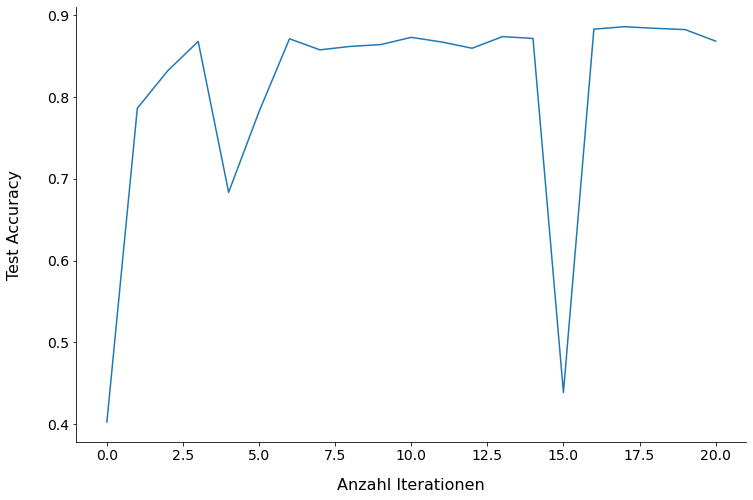

In [40]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

data = np.vstack((np.arange(num_queries+1), np.array(results)))
sns.lineplot(x=0, y=1, data=data)

plt.xlabel('Anzahl Iterationen', labelpad=15)
plt.ylabel('Test Accuracy', labelpad=25)

sns.despine()